# 1. Importing the Libraries

In [94]:
%reload_ext nb_black
"""Main"""
import os
import pickle
import gzip
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 100)

"""Data Visualization"""
import seaborn as sns
color = sns.color_palette()
import matplotlib.pyplot as plt

"""Data Preparation and Model Evaluation"""
from scipy import stats
from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection

"""Machine Learning Alogrithms"""
import xgboost as xgb
import lightgbm as lgb
from sklearn import linear_model
from sklearn import ensemble
print("Libraries Imported!!")

Libraries Imported!!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 2. Load the MNIST datasets

In [106]:
with gzip.open("./input/mnist.pkl.gz", "rb") as f:
    train_set, validation_set, test_set = pickle.load(f, encoding="latin1")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [107]:
X_train, y_train = train_set[0], train_set[1]
X_validation, y_validation = validation_set[0], validation_set[1]
X_test, y_test = test_set[0], test_set[1]

# Verify shape of datasets
print("Type & Shape of X_train: ", type(X_train), X_train.shape)
print("Type & Shape of y_train: ", type(y_train), y_train.shape)
print("Shape of X_validation: ", X_validation.shape)
print("Shape of y_validation: ", y_validation.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Type & Shape of X_train:  <class 'numpy.ndarray'> (50000, 784)
Type & Shape of y_train:  <class 'numpy.ndarray'> (50000,)
Shape of X_validation:  (10000, 784)
Shape of y_validation:  (10000,)
Shape of X_test:  (10000, 784)
Shape of y_test:  (10000,)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [108]:
X_train = pd.DataFrame(data=X_train, columns=[f"col_{i}" for i in range(X_train.shape[1])])
y_train = pd.Series(y_train, name="Class")

X_validation =  pd.DataFrame(data=X_validation, columns=[f"col_{i}" for i in range(X_train.shape[1])])
y_validation = pd.Series(y_validation, name="Class")

X_test = pd.DataFrame(data=X_test, columns=[f"col_{i}" for i in range(X_train.shape[1])])
y_test = pd.Series(y_test, name="Class")

print("\nTraining set")
display(pd.concat([X_train, y_train], axis=1).head())

print("\nValidation_set")
display(pd.concat([X_validation, y_validation], axis=1).head())

print("\nTest set")
display(pd.concat([X_test, y_test], axis=1).head())


Training set


,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20,col_21,col_22,col_23,col_24,col_25,col_26,col_27,col_28,col_29,col_30,col_31,col_32,col_33,col_34,col_35,col_36,col_37,col_38,col_39,col_40,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,...,col_735,col_736,col_737,col_738,col_739,col_740,col_741,col_742,col_743,col_744,col_745,col_746,col_747,col_748,col_749,col_750,col_751,col_752,col_753,col_754,col_755,col_756,col_757,col_758,col_759,col_760,col_761,col_762,col_763,col_764,col_765,col_766,col_767,col_768,col_769,col_770,col_771,col_772,col_773,col_774,col_775,col_776,col_777,col_778,col_779,col_780,col_781,col_782,col_783,Class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.054688,0.574219,0.984375,0.164062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9



Validation_set


,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20,col_21,col_22,col_23,col_24,col_25,col_26,col_27,col_28,col_29,col_30,col_31,col_32,col_33,col_34,col_35,col_36,col_37,col_38,col_39,col_40,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,...,col_735,col_736,col_737,col_738,col_739,col_740,col_741,col_742,col_743,col_744,col_745,col_746,col_747,col_748,col_749,col_750,col_751,col_752,col_753,col_754,col_755,col_756,col_757,col_758,col_759,col_760,col_761,col_762,col_763,col_764,col_765,col_766,col_767,col_768,col_769,col_770,col_771,col_772,col_773,col_774,col_775,col_776,col_777,col_778,col_779,col_780,col_781,col_782,col_783,Class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0625,0.992188,0.957031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6



Test set


,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20,col_21,col_22,col_23,col_24,col_25,col_26,col_27,col_28,col_29,col_30,col_31,col_32,col_33,col_34,col_35,col_36,col_37,col_38,col_39,col_40,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,...,col_735,col_736,col_737,col_738,col_739,col_740,col_741,col_742,col_743,col_744,col_745,col_746,col_747,col_748,col_749,col_750,col_751,col_752,col_753,col_754,col_755,col_756,col_757,col_758,col_759,col_760,col_761,col_762,col_763,col_764,col_765,col_766,col_767,col_768,col_769,col_770,col_771,col_772,col_773,col_774,col_775,col_776,col_777,col_778,col_779,col_780,col_781,col_782,col_783,Class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.472656,0.992188,0.808594,0.070312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 3. Explore the data

In [109]:
X_train.isna().sum().sum()

0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [110]:
X_train.dtypes

col_0      float32
col_1      float32
col_2      float32
col_3      float32
col_4      float32
            ...   
col_779    float32
col_780    float32
col_781    float32
col_782    float32
col_783    float32
Length: 784, dtype: object

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [112]:
X_train.describe()  

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20,col_21,col_22,col_23,col_24,col_25,col_26,col_27,col_28,col_29,col_30,col_31,col_32,col_33,col_34,col_35,col_36,col_37,col_38,col_39,col_40,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,...,col_734,col_735,col_736,col_737,col_738,col_739,col_740,col_741,col_742,col_743,col_744,col_745,col_746,col_747,col_748,col_749,col_750,col_751,col_752,col_753,col_754,col_755,col_756,col_757,col_758,col_759,col_760,col_761,col_762,col_763,col_764,col_765,col_766,col_767,col_768,col_769,col_770,col_771,col_772,col_773,col_774,col_775,col_776,col_777,col_778,col_779,col_780,col_781,col_782,col_783
count,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.0,50000.0,50000.0,50000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000010,0.000037,0.000017,7.031250e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000001,0.000004,0.000044,0.000108,0.000155,0.000210,0.000380,0.000570,0.000642,0.000669,0.000713,0.000677,0.000694,0.000521,0.000330,0.000249,0.000214,0.000079,...,0.002183,0.004780,0.009270,0.013831,0.018621,0.022454,0.023881,0.023494,0.021288,0.017397,0.013975,0.010081,0.006603,0.003967,0.002168,0.001039,0.000333,0.000067,2.343750e-07,0.000005,0.0,0.0,0.0,0.0,0.0,0.0,0.000012,0.000067,0.000173,0.000377,0.000501,0.000709,0.001159,0.001440,0.001910,0.002044,0.002479,0.002171,0.001725,0.001215,0.000739,0.000354,0.000204,0.000090,0.000071,0.000009,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002034,0.005825,0.003773,1.572235e-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000280,0.000833,0.004514,0.008922,0.010815,0.012096,0.016717,0.020661,0.021536,0.021707,0.022915,0.022455,0.022953,0.019508,0.015710,0.013526,0.012842,0.007018,...,0.040143,0.059599,0.084711,0.102658,0.119281,0.130512,0.133990,0.132425,0.126544,0.113353,0.102340,0.086395,0.070670,0.054549,0.041037,0.027221,0.014589,0.005078,5.240784e-05,0.001031,0.0,0.0,0.0,0.0,0.0,0.0,0.001872,0.007228,0.010341,0.016520,0.019059,0.023204,0.027897,0.032074,0.037495,0.037785,0.042861,0.039891,0.034687,0.029491,0.022784,0.015424,0.012080,0.007218,0.007181,0.001483,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Display the images

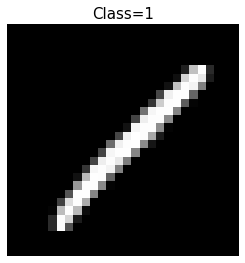

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [113]:
import random
idx = random.randint(0, 1000)

img_array = X_train.loc[idx, :].values
img_label = y_train[idx]

plt.imshow(img_array.reshape(28, -1), cmap="gray")
plt.title(f"Class={img_label}", fontsize=15)
plt.tight_layout()
plt.axis("off")
plt.show()

# 4. Types of Dimensionality Reduction:
- **1. Linear projection:** 
<br/>
    It involves linearly projecting data from a high-dimensional space to a low-dimensional space. 
    <br/>
    ***Example:*** PCA, SVD(Singular Value decomposition), and random projection.
    <br/>
    <br/>
- **2. Manifold learning:**
<br/>
    Referred to as nonlinear dimensionality reduction. 
    <br/>
    ***Example:*** t-distributed stochastic neighbor embedding (t-SNE)

# 1.1 Principal Component Analysis (PCA)
- Generally we must scale the data to make sure the features are in the same relative range. However, for our MNIST digits dataset, the features are already scaled to a range of zero to one, so we can skip this step.

In [114]:
from sklearn.decomposition import PCA 

pca = PCA(n_components=784, whiten=True, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_train_pca = pd.DataFrame(X_train_pca, index=X_train.index)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Validating the variance covered over the Principal Components

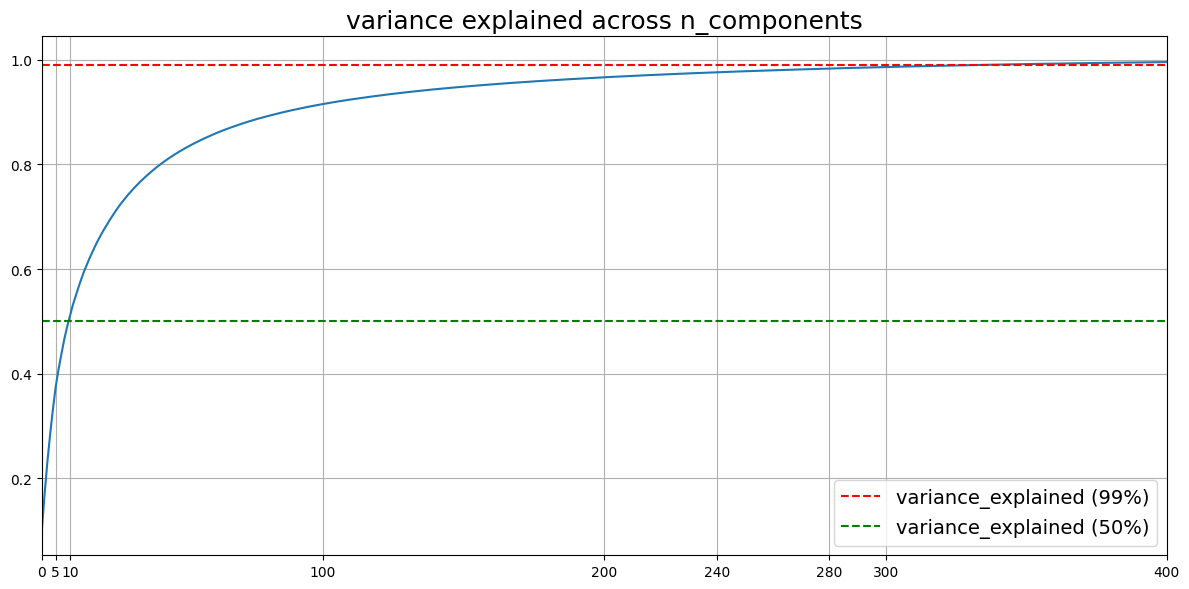

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [115]:
explained_variance_ratio = pca.explained_variance_ratio_

cummulative_variance = np.cumsum(explained_variance_ratio)

fig = plt.figure(figsize=(12, 6), dpi=100, tight_layout=True) 
plt.plot(cummulative_variance)
plt.grid()
plt.axhline(y=0.99, color="red", linestyle="--", label="variance_explained (99%)")
plt.axhline(y=0.50, color="green", linestyle="--", label="variance_explained (50%)")
plt.xlim([0, 350])
plt.xticks([0, 5, 10, 100, 200, 240, 280, 300, 400])
plt.legend(loc="lower right",fontsize=14)
plt.title("variance explained across n_components", fontsize=18)

plt.show()

### Conclusion:
- The first 10 components in total capture approximately 50% of the variance.
- the first 100 components over 90%, and 
- the first 300 components almost 99% of the variance,
- *the information in the rest of the principal components is of negligible value.*
----

## Visualize the separation of points in space
Plot the observations in two dimensions. Specifically, we will display a scatterplot of the first and second principal components and mark the observations by the true label.

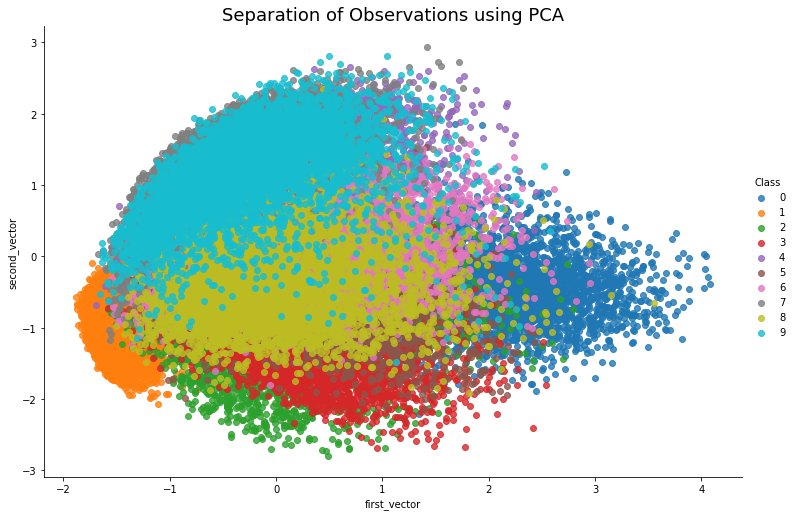

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [116]:
def scatter_plot(df_pca, y_label, algoName, height=7, aspect=1.5):
    """This function plots the 1st two components of PCA and true label as a  marker"""
    tempDF = df_pca.loc[:, 0:1]
    tempDF = pd.concat([tempDF, y_label], axis=1)
    tempDF.columns = ["first_vector", "second_vector", "Class"]
    
    sns.lmplot(data=tempDF, 
               x="first_vector",
               y="second_vector", 
               hue="Class", 
               scatter=True, 
               fit_reg=False, 
               height=height, 
               aspect=aspect)
    
    title_ = f"Separation of Observations using {algoName}"
    plt.title(title_, size=18)
    plt.show()
        
scatter_plot(X_train_pca, y_train, "PCA")

# 1.2 Incremental PCA
- For datasets that are very large and cannot fit in memory.
- we can perform PCA incrementally in small batches, where `each batch is able to fit in memory.`

In [71]:
from sklearn.decomposition import IncrementalPCA

n_components = 784
batch_size = None

incrementalPCA = IncrementalPCA(n_components=n_components,
                                batch_size=batch_size)

X_train_incrementalPCA = incrementalPCA.fit_transform(X_train)
X_train_incrementalPCA = pd.DataFrame(X_train_incrementalPCA, index=X_train.index)

<IPython.core.display.Javascript object>

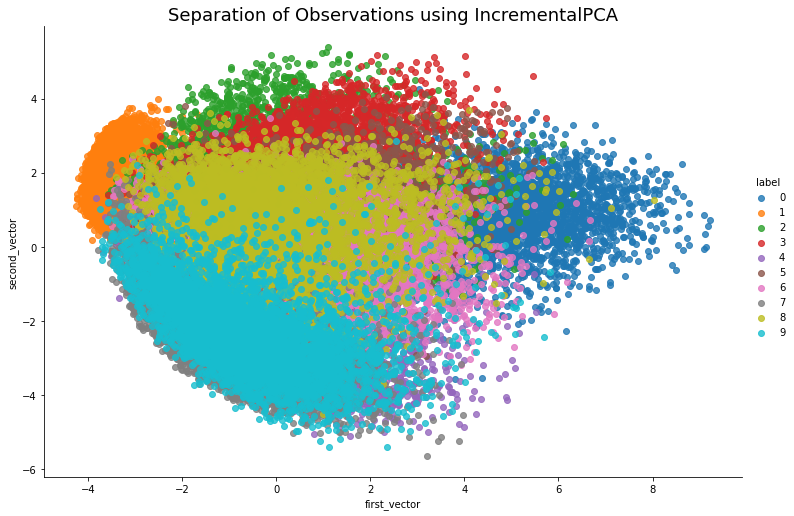

In [274]:
scatter_plot(X_train_incrementalPCA, y_train, "IncrementalPCA", height=7, aspect=1.5)

## 1.3 Kernel PCA

## 2.1 t-distributed stochastic neighbor embedding (t-SNE)